In [1]:
import os, shutil

import xarray as xr
import dask.dataframe as dd

#from rechunker import rechunk
# need version 0.3.3, see: https://github.com/pangeo-data/rechunker/issues/92

%matplotlib inline
from matplotlib import pyplot as plt

import mitequinox.plot as pl
import mitequinox.utils as ut
import mitequinox.parcels as pa

In [2]:
import pandas as pd
import numpy as np

In [3]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=2
                 )
#
client = Client(cluster)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.1.104:8787/status,
Dashboard: http://10.148.1.104:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.1.104:46229,Workers: 0
Dashboard: http://10.148.1.104:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon
def plot_site(bbox,k,colmap='RdBu_r',figsize=(5,5)):

    central_lon = (bbox[0]+bbox[1])*0.5
    central_lat = (bbox[2]+bbox[3])*0.5

    polygon = Polygon([(bbox[0], bbox[2]), 
                       (bbox[1], bbox[2]), 
                       (bbox[1], bbox[3]), 
                       (bbox[0], bbox[3]), 
                       (bbox[0], bbox[2]),
                      ])
    #poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=world.crs)
    gdf = tracks["swath"]
    gdf_clipped = gpd.clip(gdf, polygon)

    #crs = ccrs.Orthographic(central_lon, central_lat)
    crs = ccrs.AlbersEqualArea(central_lon, central_lat)

    crs_proj4 = crs.proj4_init

    fig, ax = plt.subplots(1, k, 
                           subplot_kw={'projection': crs},
                           figsize=figsize,
                          )
    #ds_Lstats[V].plot(ax=ax,transform=ccrs.PlateCarree(),y='lat',vmax=vmax,cmap=colmap)
#    ax.set_extent(bbox)

    #_gdf = gdf.cx[bbox[0]:bbox[1], bbox[2]:bbox[3]]
    _gdf = gdf_clipped
    gdf_crs = _gdf.to_crs(crs_proj4)
    ax.add_geometries(gdf_crs['geometry'],
                         crs=crs,
                         facecolor='grey', 
                         edgecolor='black',
                          alpha=0.5,
                         )

    ax.gridlines(draw_labels=True)
    #    ax.coastlines(resolution='50m')
    ax.set_extent(bbox)
#    for a in ax:
#        a.add_geometries(gdf_crs['geometry'],
#                         crs=crs,
#                         facecolor='grey', 
#                         edgecolor='black',
#                          alpha=0.5,
#                         )

#        a.gridlines(draw_labels=True)
    #    ax.coastlines(resolution='50m')
#        a.set_extent(bbox)
    return fig, ax
def plot_swot(df,col,bbox,k,vmax,colmap,figsize):
    fig,ax = plot_site(bbox,k,figsize=figsize)
    if k!=1:
        for V,c,a in zip(df,col,ax):
            V.plot.scatter(ax=a,transform=ccrs.PlateCarree(),x='lon',y='lat',c=c,s=5,cmap=colmap,vmax=vmax)
    else:
        df.plot.scatter(ax=ax,transform=ccrs.PlateCarree(),x='lon',y='lat',c=col,s=5,cmap=colmap,vmax=vmax)
    fig.tight_layout()

### California

In [6]:
# output archives
out_dir = os.path.join("/home/datawork-lops-osi/equinox/mit4320/diags/", "regional_cal")
llc_zarr = os.path.join(out_dir, "llc_filtered.zarr")

parcels_index= 'filtered_itide_Tw30_sd_band04'
parcels_name = "llc_parcels_"+parcels_index
parcels_path = os.path.join(out_dir, parcels_name)


In [7]:
grid = xr.open_zarr(ut.work_data_dir+'rechunked/SSU_rot.zarr')[['Depth']]

/dev/shm/pbs.9400999.datarmor0/ipykernel_53429/2014925786.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  grid = xr.open_zarr(ut.work_data_dir+'rechunked/SSU_rot.zarr')[['Depth']]


In [8]:
ds = xr.open_zarr(llc_zarr)


In [9]:
grd = grid.sel(face=10,i=ds.i,j=ds.j).compute()
#grd = grd.chunk({'i':128,'j':120})
ds = xr.merge([ds,grd])

In [10]:
#Lagrangian outputs
df = dd.read_parquet(parcels_path)
df = df.repartition(npartitions=14).persist()

In [27]:
bbox = [-128, -118, 30, 40] # california

In [28]:
ds_var = ds[['variance','lon','lat','Depth']].compute()
ds

<xarray.Dataset>
Dimensions:                   (j: 120, i: 159, time: 8640)
Coordinates:
    face                      int64 10
  * i                         (i) int64 2768 2772 2776 2780 ... 3392 3396 3400
  * j                         (j) int64 0 4 8 12 16 20 ... 460 464 468 472 476
  * time                      (time) datetime64[ns] 2011-11-15 ... 2012-11-08...
Data variables:
    SSU_rot_demodulated       (j, i, time) complex128 dask.array<chunksize=(120, 128, 1024), meta=np.ndarray>
    SSU_rot_demodulated_imag  (j, i, time) float64 dask.array<chunksize=(120, 128, 1024), meta=np.ndarray>
    SSU_rot_demodulated_real  (j, i, time) float64 dask.array<chunksize=(120, 128, 1024), meta=np.ndarray>
    lat                       (j, i) float64 dask.array<chunksize=(120, 128), meta=np.ndarray>
    lon                       (j, i) float64 dask.array<chunksize=(120, 128), meta=np.ndarray>
    variance                  (j, i) float64 dask.array<chunksize=(120, 128), meta=np.ndarray>
    Depth                     (j, i) float32 4.531e+03 4.394e+03 ... 3.355e+03

In [29]:
tracks = ut.load_swot_tracks()
gdf = tracks['swath']
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon

central_lon = (bbox[0]+bbox[1])*0.5
central_lat = (bbox[2]+bbox[3])*0.5
polygon = Polygon([(bbox[0], bbox[2]), 
                       (bbox[1], bbox[2]), 
                       (bbox[1], bbox[3]), 
                       (bbox[0], bbox[3]), 
                       (bbox[0], bbox[2]),
                      ])
gdf_clipped = gpd.clip(gdf, polygon)
crs = ccrs.AlbersEqualArea(central_lon, central_lat)
crs_proj4 = crs.proj4_init
_gdf = gdf_clipped
gdf_crs = _gdf.to_crs(crs_proj4)

In [30]:
ds_var.lon[:,0].shape
ds_var = ds_var.assign_coords({'lon':ds_var.lon[:,0],'lat':ds_var.lat[0,:]})

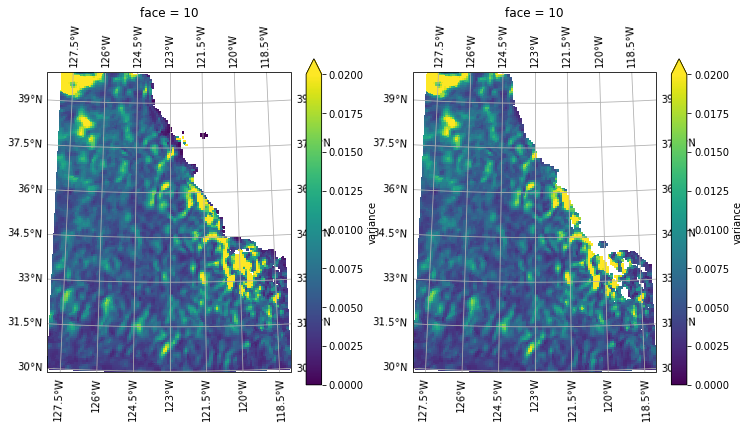

In [33]:
#fig,ax = plot_site(bbox,1,figsize=(5,5))
fig, ax = plt.subplots(1,2,subplot_kw={'projection': crs},
                        figsize=(12,6),
                          )
ds_var.variance.plot(ax=ax[0],x='lon',y='lat',vmax=0.02,vmin=0,transform=ccrs.PlateCarree())
ax[0].gridlines(draw_labels=True)

ds_var.where(ds_var.Depth>=500).variance.plot(ax=ax[1],x='lon',y='lat',vmax=0.02,vmin=0,transform=ccrs.PlateCarree())
ax[1].gridlines(draw_labels=True)

In [38]:
df = df.repartition(npartitions=14).persist()


In [35]:
traj_size = df[(df.lon<=bbox[1])
               &(df.lon>=bbox[0])
               &(df.lat<=bbox[3])
               &(df.lat>=bbox[2])].groupby('trajectory').apply(lambda x : x.count()).z.compute()

/dev/shm/pbs.9400999.datarmor0/ipykernel_43743/3044436570.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  traj_size = df[(df.lon<=bbox[1])


KeyboardInterrupt: 

In [16]:
id_flt0 = traj_size.index[traj_size.argmax()]
flt0 = df[df.trajectory==id_flt0].compute()

In [17]:
flt0 = flt0[(flt0.lon<=bbox[1])&(flt0.lon>=bbox[0])
            &(flt0.lat<=bbox[3])&(flt0.lat>=bbox[2])]

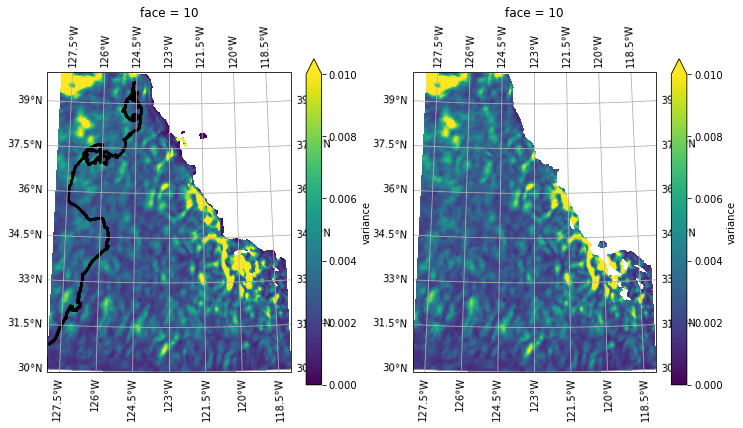

In [18]:
fig, ax = plt.subplots(1,2,subplot_kw={'projection': crs},
                        figsize=(12,6),
                          )
ds_var.variance.plot(ax=ax[0],x='lon',y='lat',vmax=0.01,vmin=0,transform=ccrs.PlateCarree())
ax[0].gridlines(draw_labels=True)
ax[0].scatter(x=flt0.lon,y=flt0.lat,c='k',transform=ccrs.PlateCarree(),s=1)
ds_var.where(ds_var.Depth>=500).variance.plot(ax=ax[1],x='lon',y='lat',vmax=0.01,vmin=0,transform=ccrs.PlateCarree())
ax[1].gridlines(draw_labels=True)

In [19]:
flt0['zonal_velocity_demodulated'] = flt0['zonal_velocity_demodulated_real']+1j*flt0['zonal_velocity_demodulated_imag']

In [42]:
mid_id = flt0.index.size//2
flt_mid = flt0.iloc[mid_id]
flt0 = flt0.iloc[mid_id-20*24:mid_id+20*24]
flt_mid

trajectory                              3.700162e+07+0.000000e+00j
lat                                     3.703707e+01+0.000000e+00j
lon                                    -1.258190e+02+0.000000e+00j
z                                       0.000000e+00+0.000000e+00j
zonal_velocity                         -4.730991e+03+0.000000e+00j
meridional_velocity                     1.094872e+04+0.000000e+00j
waterdepth                              4.394380e+03+0.000000e+00j
zonal_velocity_hat_real                -5.724043e-02+0.000000e+00j
zonal_velocity_hat_imag                 3.548231e-02+0.000000e+00j
zonal_velocity_demodulated_real         5.656282e-02+0.000000e+00j
zonal_velocity_demodulated_imag         3.655283e-02+0.000000e+00j
meridional_velocity_hat_real            7.375995e-03+0.000000e+00j
meridional_velocity_hat_imag           -5.849495e-02+0.000000e+00j
meridional_velocity_demodulated_real   -5.602556e-02+0.000000e+00j
meridional_velocity_demodulated_imag    1.836306e-02+0.000000e

In [21]:
np.real(flt_mid.lon)

-125.81896997218739

In [22]:
ds = ds.assign_coords({'lon':ds.lon[:,0].compute(),'lat':ds.lat[0,:].compute()})
#ds_mid = ds.sel(lon=np.real(flt_mid.lon),lat=np.real(flt_mid.lat),method='nearest').persist()
ds

<xarray.Dataset>
Dimensions:                   (j: 480, i: 636, time: 8640)
Coordinates:
    face                      int64 10
  * i                         (i) int64 2765 2766 2767 2768 ... 3398 3399 3400
  * j                         (j) int64 0 1 2 3 4 5 ... 474 475 476 477 478 479
    lat                       (i) float64 39.99 39.97 39.96 ... 30.03 30.01
    lon                       (j) float64 -128.0 -128.0 -127.9 ... -118.0 -118.0
  * time                      (time) datetime64[ns] 2011-11-15 ... 2012-11-08...
Data variables:
    Depth                     (j, i) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
    SSU_rot_demodulated_imag  (j, i, time) float64 dask.array<chunksize=(128, 128, 1024), meta=np.ndarray>
    SSU_rot_demodulated_real  (j, i, time) float64 dask.array<chunksize=(128, 128, 1024), meta=np.ndarray>
    XC                        (j, i) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
    YC                        (j, i) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
    variance                  (j, i) float64 dask.array<chunksize=(128, 128), meta=np.ndarray>

In [24]:
ds = ds.swap_dims({"i":"lat","j":"lon"})

In [43]:
ds_mid = ds.sel(lat=flt_mid.lat,lon=flt_mid.lon,method='nearest').persist()
ds_mid

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/utils.py:76: ComplexWarning: Casting complex values to real discards the imaginary part
  label = np.asarray(label, dtype=coords_dtype)


<xarray.Dataset>
Dimensions:                   (time: 8640)
Coordinates:
    face                      int64 10
    i                         int64 2961
    j                         int64 104
    lat                       float64 37.03
    lon                       float64 -125.8
  * time                      (time) datetime64[ns] 2011-11-15 ... 2012-11-08...
Data variables:
    Depth                     float32 dask.array<chunksize=(), meta=np.ndarray>
    SSU_rot_demodulated_imag  (time) float64 dask.array<chunksize=(1024,), meta=np.ndarray>
    SSU_rot_demodulated_real  (time) float64 dask.array<chunksize=(1024,), meta=np.ndarray>
    XC                        float32 dask.array<chunksize=(), meta=np.ndarray>
    YC                        float32 dask.array<chunksize=(), meta=np.ndarray>
    variance                  float64 dask.array<chunksize=(), meta=np.ndarray>

In [44]:
import seaborn as sns

<AxesSubplot:xlabel='zonal_velocity_demodulated', ylabel='Count'>

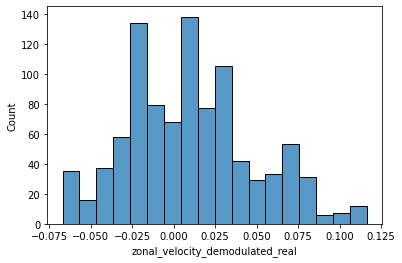

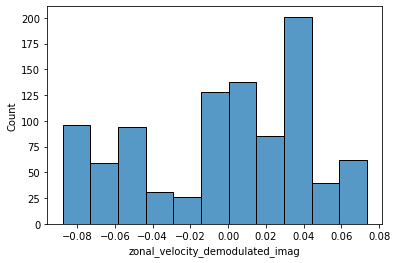

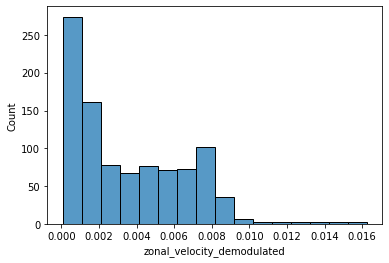

In [45]:
sns.histplot(flt0.zonal_velocity_demodulated_real)
plt.figure()
sns.histplot(flt0.zonal_velocity_demodulated_imag)
plt.figure()
sns.histplot(np.abs(flt0.zonal_velocity_demodulated)**2)

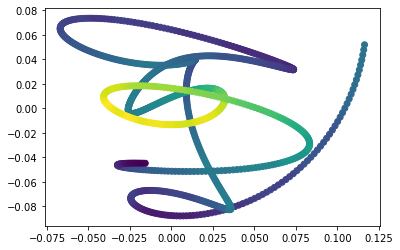

In [46]:
plt.scatter(flt0.zonal_velocity_demodulated_real,flt0.zonal_velocity_demodulated_imag,c=flt0.lat)

In [47]:
ds_mid['SSU_rot_demodulated'] = ds_mid['SSU_rot_demodulated_real']+1j*ds_mid['SSU_rot_demodulated_imag']

In [48]:
ds_mid = ds_mid.sel(time=flt0.index).to_dataframe()

In [49]:
ds_mid

,Depth,SSU_rot_demodulated_imag,SSU_rot_demodulated_real,XC,YC,face,i,j,lat,lon,variance,SSU_rot_demodulated
time,,,,,,,,,,,,
2012-03-27 14:00:00,4478.529785,-0.025122,0.019970,-125.822914,37.032162,10,2961,104,37.032162,-125.822914,0.003815,0.019970-0.025122j
2012-03-27 15:00:00,4478.529785,-0.031144,0.004927,-125.822914,37.032162,10,2961,104,37.032162,-125.822914,0.003815,0.004927-0.031144j
2012-03-27 16:00:00,4478.529785,-0.022331,-0.008351,-125.822914,37.032162,10,2961,104,37.032162,-125.822914,0.003815,-0.008351-0.022331j
2012-03-27 17:00:00,4478.529785,-0.006834,-0.008144,-125.822914,37.032162,10,2961,104,37.032162,-125.822914,0.003815,-0.008144-0.006834j
2012-03-27 18:00:00,4478.529785,0.000951,0.005124,-125.822914,37.032162,10,2961,104,37.032162,-125.822914,0.003815,0.005124+0.000951j
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-05-06 09:00:00,4478.529785,-0.001476,-0.001551,-125.822914,37.032162,10,2961,104,37.032162,-125.822914,0.003815,-0.001551-0.001476j
2012-05-06 10:00:00,4478.529785,0.000905,0.003608,-125.822914,37.032162,10,2961,104,37.032162,-125.822914,0.003815,0.003608+0.000905j
2012-05-06 11:00:00,4478.529785,-0.002381,0.008636,-125.822914,37.032162,10,2961,104,37.032162,-125.822914,0.003815,0.008636-0.002381j


<AxesSubplot:xlabel='time'>

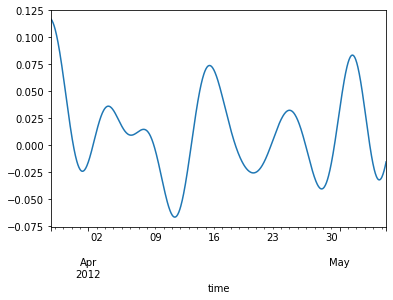

In [62]:
flt0.zonal_velocity_demodulated_real.plot()

<AxesSubplot:xlabel='time'>

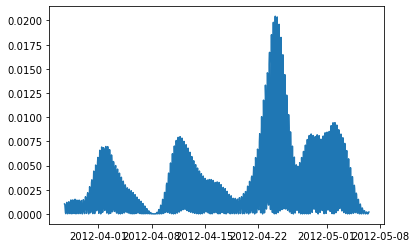

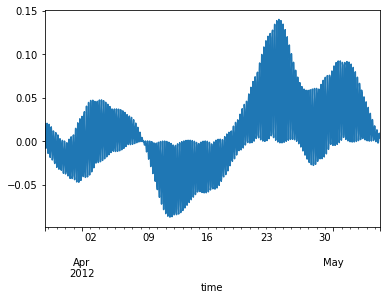

In [55]:
plt.plot(ds_mid.index,np.abs(ds_mid.SSU_rot_demodulated)**2)

plt.figure()
ds_mid.SSU_rot_demodulated_real.plot()

<AxesSubplot:xlabel='time'>

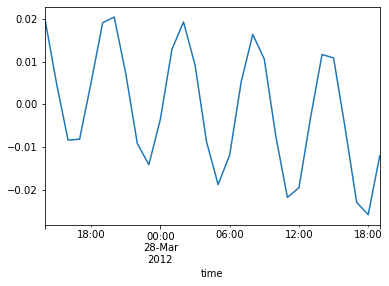

In [59]:
ds_mid.SSU_rot_demodulated_real.iloc[0:30].plot()

In [61]:
5e-5*np.sin(2*np.pi*35/360)*3600*24

2.477850205036519

<AxesSubplot:xlabel='SSU_rot_demodulated', ylabel='Count'>

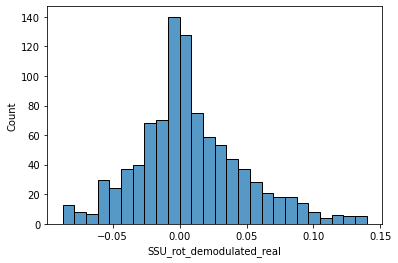

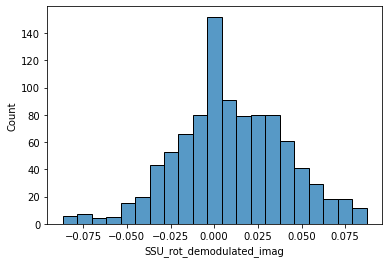

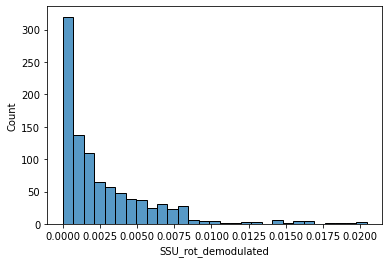

In [50]:
sns.histplot(ds_mid.SSU_rot_demodulated_real)
plt.figure()
sns.histplot(ds_mid.SSU_rot_demodulated_imag)
plt.figure()
sns.histplot(np.abs(ds_mid.SSU_rot_demodulated)**2)

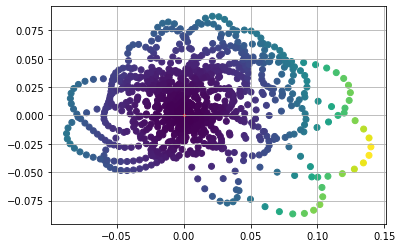

In [53]:
plt.scatter(ds_mid.SSU_rot_demodulated_real,ds_mid.SSU_rot_demodulated_imag,c=np.abs(ds_mid.SSU_rot_demodulated)**2)
plt.scatter(0,0,s=4,c='r')
plt.grid();

In [13]:
def binned_mean(df,dl,bbox,k,group,skipna=False):
    lonmin,lonmax = bbox[0],bbox[1]
    latmin,latmax = bbox[2],bbox[3]
    lon = np.arange(lonmin,lonmax, dl)
    lat = np.arange(latmin, latmax, dl)
    df['lon_cut'] = pd.cut(df['lon'], lon)
    df['lat_cut'] = pd.cut(df['lat'], lat)
    df_count = df.groupby(group).apply(lambda x:x.count())
    df_count = pa.add_geodata(df_count,lonlat=group)
    df_count = (df_count
     #     .drop(columns=['Coordinates'])
          .set_index([V.split('_')[0] for V in group])
         .to_xarray()
        )
    df_count = df_count.assign_coords({V.split('_')[0]:np.around(df[V.split('_')[0]],decimals=k) for V in group})
    if len(group)==1:
        df = df.groupby(group).apply(lambda x:x.mean(skipna=True))
    else:
        df = df.groupby(group).apply(lambda x:x.mean(skipna=skipna))
    df = pa.add_geodata(df,lonlat=group)
    df = (df
     #     .drop(columns=['Coordinates'])
          .set_index([V.split('_')[0] for V in group])
         .to_xarray()
        )
    df = df.assign_coords({V.split('_')[0]:np.around(df[V.split('_')[0]],decimals=k) for V in group})
    df['count'] = df_count.SSU_rot
    #df = df.assign_coords({'lat':np.around(df.lat,decimals=k)
    #                                                 ,'lon':np.around(df.lon,decimals=k)})
    return df

In [36]:
def binned_Lmean(df,dl,bbox,group,skipna=False):
    lonmin,lonmax = bbox[0],bbox[1]#df.lon.values.max()
    latmin,latmax = bbox[2],bbox[3]#df.lat.values.min(),df.lat.values.max()
    lon = np.arange(lonmin,lonmax, dl)
    lat = np.arange(latmin, latmax, dl)
    df['lon'] = (df['lon']+180)%360 - 180
    df['lon_cut'] = pd.cut(df['lon'], lon)
    df['lat_cut'] = pd.cut(df['lat'], lat)
    df_reset = df.reset_index()
    #group = ['lon_cut','lat_cut']
    df_count = df.groupby(group).count()
    df_count = pa.add_geodata(df_count,lonlat=group)
    df_count = (df_count
     #     .drop(columns=['Coordinates'])
          .set_index([V.split('_')[0] for V in group])
         .to_xarray()
        )
    df_mean = df_reset.drop(columns=['trajectory','z','lat','lon']
                  ).groupby(group).agg(lambda x: x.mean(skipna=skipna))
    df_mean = df_mean.rename(columns={V:V+'_binned' for V in df_mean.columns})
    df_merged = (df_reset
                 .merge(df_mean.reset_index(), on=group)
                )
    df_merged = df_merged.set_index('time')
    for V in ['zonal_velocity','meridional_velocity']:
        #df_merged[V+'_var_ibinned'] = (df_merged[V]-df_merged[V+'_mean_binned'])**2
        df_merged[V+'_var_binned'] = (df_merged[V]-df_merged[V+'_binned'])**2
        #df_merged[V+'_var_itime'] = (df_merged[V]-df_merged[V+'_mean'])**2
    #df_merged['MKE_itime'] = df_merged['zonal_velocity_mean']**2+df_merged['meridional_velocity_mean']**2
    df_merged['KE'] = df_merged['zonal_velocity']**2+df_merged['meridional_velocity']**2
    #dfL_mean = df_merged.groupby(['lon_cut','lat_cut']).agg(lambda x: x.mean(skipna=False))
    #dfL_mean = pa.add_geodata(dfL_mean)
    #dfL_mean = (dfL_mean
    #          .set_index(['lon', 'lat'])
    #         .to_xarray()
    #        )
    if len(group)==1:
        dfL_mean = df_merged.groupby(group).agg(lambda x: x.mean(skipna=True))
    else:
        dfL_mean = df_merged.groupby(group).agg(lambda x: x.mean(skipna=skipna))
    dfL_mean = pa.add_geodata(dfL_mean,lonlat=group)
    dfL_mean = (dfL_mean
          .set_index([V.split('_')[0] for V in group])
         .to_xarray()
        )
    #dfL_mean['count'] = df_count.zonal_velocity
    return dfL_mean,df_merged,df_count

In [15]:
bbox = [-128, -118, 30, 40] # california

In [16]:

dl=1.
group = ['lon_cut','lat_cut']
#dfE_1dl,dfE_count_1dl = binned_mean(dfE_mean,dl,bbox,1,group,skipna=True)
dfE_1dl = binned_mean(dfE_mean,dl,bbox,1,group,skipna=True)

/dev/shm/pbs.9388934.datarmor0/ipykernel_56906/3105971479.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.groupby(group).apply(lambda x:x.mean(skipna=skipna))


In [17]:
dl=.1
dfE_01dl = binned_mean(dfE_mean,dl,bbox,2,group,skipna=True)

/dev/shm/pbs.9388934.datarmor0/ipykernel_56906/3105971479.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.groupby(group).apply(lambda x:x.mean(skipna=skipna))


In [18]:
dfE_1dlat = binned_mean(dfE_mean,1.,bbox,1,['lat_cut'])
dfE_01dlat = binned_mean(dfE_mean,.1,bbox,2,['lat_cut'])

/dev/shm/pbs.9388934.datarmor0/ipykernel_56906/3105971479.py:17: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.groupby(group).apply(lambda x:x.mean(skipna=True))
/dev/shm/pbs.9388934.datarmor0/ipykernel_56906/3105971479.py:17: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.groupby(group).apply(lambda x:x.mean(skipna=True))


In [19]:

#Lagrangian outputs
df = dd.read_parquet(parcels_path)

In [20]:
#df = df.drop(columns=['SST_interp','SSS_interp','Eta_interp','salinity','temperature','sea_level']).rename(columns={'SSU_interp':'zonal_velocity_mean','SSV_interp':'meridional_velocity_mean'})
#df = pa.degs2ms(df) #Convert in m/s 


df= df.compute()

#### Number of floats

In [21]:
lonmin,lonmax = bbox[0],bbox[1]#df.lon.values.max()
latmin,latmax = bbox[2],bbox[3]#df.lat.values.min(),df.lat.values.max()
dl = 1.
lon = np.arange(lonmin,lonmax, dl)
lat = np.arange(latmin, latmax, dl)
df['lon'] = (df['lon']+180)%360 - 180
df['lon_cut'] = pd.cut(df['lon'], lon)
df['lat_cut'] = pd.cut(df['lat'], lat)

In [22]:
tracks = ut.load_swot_tracks()
gdf = tracks['swath']

In [23]:
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon

central_lon = (bbox[0]+bbox[1])*0.5
central_lat = (bbox[2]+bbox[3])*0.5
polygon = Polygon([(bbox[0], bbox[2]), 
                       (bbox[1], bbox[2]), 
                       (bbox[1], bbox[3]), 
                       (bbox[0], bbox[3]), 
                       (bbox[0], bbox[2]),
                      ])
gdf_clipped = gpd.clip(gdf, polygon)
crs = ccrs.AlbersEqualArea(central_lon, central_lat)
crs_proj4 = crs.proj4_init
_gdf = gdf_clipped
gdf_crs = _gdf.to_crs(crs_proj4)

In [24]:
#gdf_clipped.distance(gdf_clipped.shape)
#np.abs(gdf_clipped.geometry.bounds.maxx-gdf_clipped.geometry.bounds.minx)/2
gdf_crs.geometry.bounds.maxx[18]

-38172.71253373113

In [25]:
#list(polygon.exterior.coords)
poly = list(gdf_clipped.geometry[18])

/dev/shm/pbs.9388934.datarmor0/ipykernel_56906/3128629053.py:2: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  poly = list(gdf_clipped.geometry[18])
/dev/shm/pbs.9388934.datarmor0/ipykernel_56906/3128629053.py:2: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  poly = list(gdf_clipped.geometry[18])


In [28]:
import shapely
shapely.geometry.Point(list(poly[0].exterior.coords)[2]).distance(shapely.geometry.Point(list(poly[0].exterior.coords)[35]))

1.2548416460657463

In [31]:
#df_binned = df.groupby(['lon_cut','lat_cut']).mean()
df_binned = df.groupby(['lon_cut','lat_cut']).agg(lambda x: x.mean(skipna=True))
df_binned = pa.add_geodata(df_binned,lonlat=['lon_cut','lat_cut'])

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not T

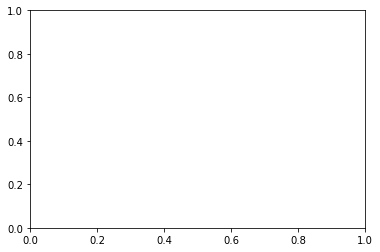

In [32]:
df_binned.plot.scatter(x='lon',y='lat',c='T',cmap='coolwarm',vmax=20)

In [33]:
df_binned = (df_binned
          .set_index([V.split('_')[0] for V in ['lon_cut','lat_cut']])
         .to_xarray()
        )

In [34]:
df_binned

<xarray.Dataset>
Dimensions:              (lon: 9, lat: 9)
Coordinates:
  * lon                  (lon) float64 -127.5 -126.5 -125.5 ... -120.5 -119.5
  * lat                  (lat) float64 30.5 31.5 32.5 33.5 ... 36.5 37.5 38.5
Data variables:
    trajectory           (lon, lat) float64 3.711e+07 3.706e+07 ... nan nan
    z                    (lon, lat) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    zonal_velocity       (lon, lat) float64 -0.0205 -0.007298 ... nan nan
    meridional_velocity  (lon, lat) float32 -0.06543 -0.06759 ... nan nan
    sea_level            (lon, lat) float32 0.4011 0.4328 0.3603 ... nan nan nan
    temperature          (lon, lat) float32 16.78 17.0 15.97 ... nan nan nan
    salinity             (lon, lat) float32 33.67 33.6 33.31 ... nan nan nan
    waterdepth           (lon, lat) float32 4.312e+03 4.289e+03 ... nan nan

In [38]:
group=['lon_cut','lat_cut']
dfL_1dl,df_merged,df_count_1dl = binned_Lmean(df,1.,bbox,group=group,skipna=True)
dfL_01dl,df_merged_01,df_count_01dl = binned_Lmean(df,0.1,bbox,group=group,skipna=True)

In [40]:
dfL_1dlat,df_merged_1dlat,df_count_1dlat = binned_Lmean(df,1.,bbox,['lat_cut'])
dfL_01dlat,df_merged_01dlat,df_count_1dlat = binned_Lmean(df,.1,bbox,['lat_cut'])

In [71]:
for V in [[dfE_1dl,dfL_1dl],[dfE_01dl,dfL_01dl],[dfE_1dlat,dfL_1dlat],[dfE_01dlat,dfL_01dlat]]:
    V[0]['MKE'] = V[0]['zonal_velocity']**2+V[0]['meridional_velocity']**2
    V[0]['EKE'] = V[0]['zonal_velocity_var']+V[0]['meridional_velocity_var']
    V[1]['MKE_i'] = V[1]['zonal_velocity_mean']**2+V[1]['meridional_velocity_mean']**2
    V[1]['MKE_b'] = V[1]['zonal_velocity']**2+V[1]['meridional_velocity']**2
    V[1]['EKE_i'] = V[1]['zonal_velocity_var_itime']+V[1]['meridional_velocity_var_itime']
    V[1]['EKE_b'] = V[1]['zonal_velocity_var_binned']+V[1]['meridional_velocity_var_binned']

### Visualization

In [41]:
bbox = [-128,-124,35,38]
df_sub = df[(df.lon<=bbox[1])&(df.lon>=bbox[0])&(df.lat<=bbox[3])&(df.lat>=bbox[2])]
ds = ds.where((ds.lon<=bbox[1])&(ds.lon>=bbox[0])&(ds.lat<=bbox[3])&(ds.lat>=bbox[2]),drop=True)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


<AxesSubplot:xlabel='lon', ylabel='lat'>

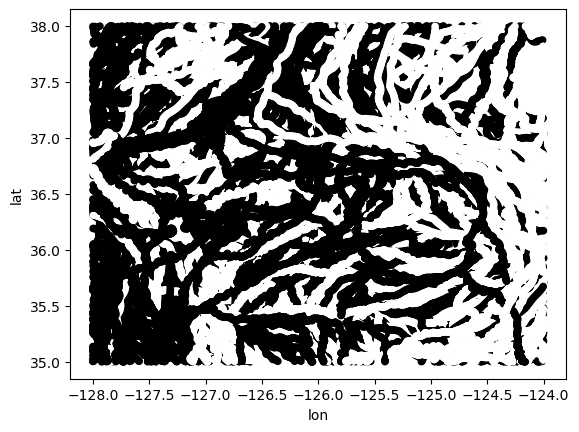

In [102]:
df_sub.plot.scatter(x='lon',y='lat',c=df_sub.trajectory)


In [105]:
traj = np.unique(df_sub.trajectory)[10]
df_selected = df_sub[np.isin(df_sub.trajectory,traj)]

Int64Index([3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
            ...
            5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
           dtype='int64', name='time', length=1141)


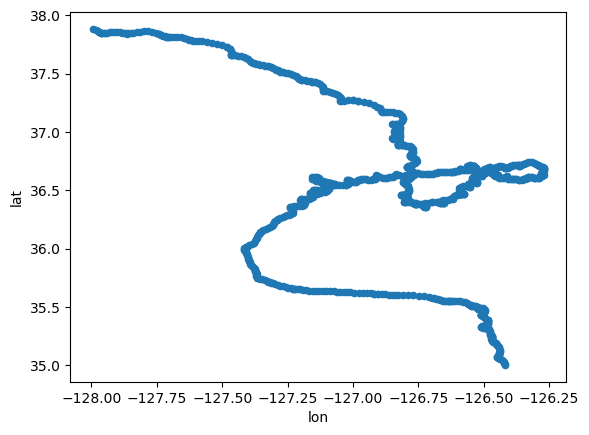

In [106]:
df_selected.plot.scatter(x='lon',y='lat')
print(df_selected.index.month)

In [107]:
df_selected = df_selected.sort_index()
#df_selected = df_selected[df_selected.index.month==4]

In [108]:
df_selected

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,zonal_velocity_mean,meridional_velocity_mean
time,,,,,,,,
2012-03-25 21:00:00,37001071,37.883498,-127.994571,0.0,0.339993,-0.200511,0.014329,-0.070996
2012-03-25 22:00:00,37001071,37.875255,-127.984270,0.0,0.266776,-0.256387,0.015732,-0.070259
2012-03-25 23:00:00,37001071,37.866039,-127.975589,0.0,0.235597,-0.250033,0.016647,-0.069993
2012-03-26 00:00:00,37001071,37.857041,-127.969617,0.0,0.175938,-0.315128,0.018498,-0.069453
2012-03-26 00:00:00,37001071,37.857041,-127.969617,0.0,0.175938,-0.315128,0.018498,-0.069453
...,...,...,...,...,...,...,...,...
2012-05-08 13:00:00,37001071,35.035120,-126.427198,0.0,0.141777,-0.297962,0.035883,-0.098030
2012-05-08 14:00:00,37001071,35.026624,-126.423640,0.0,0.103350,-0.273117,0.036053,-0.097491
2012-05-08 15:00:00,37001071,35.018753,-126.420937,0.0,0.075114,-0.252567,0.036157,-0.097031


In [109]:
_df = df_selected.loc[df_selected.index[:]]

In [110]:
i_mid = _df.index.size//2
t_start = _df.index.min()
t_end = _df.index.max()

In [111]:
t_mid = _df.index[i_mid]
lon_mid,lat_mid = _df.loc[t_mid].lon,_df.loc[t_mid].lat

In [112]:
__ds = _ds.sel(lat=lat_mid,lon=lon_mid,method='nearest')

In [113]:
__ds = __ds.sel(time=slice(t_start,t_end))

<AxesSubplot:title={'center':'lon = -124.98958587646484, lat = 35.9964599609375'}, xlabel='time', ylabel='zonal_velocity'>

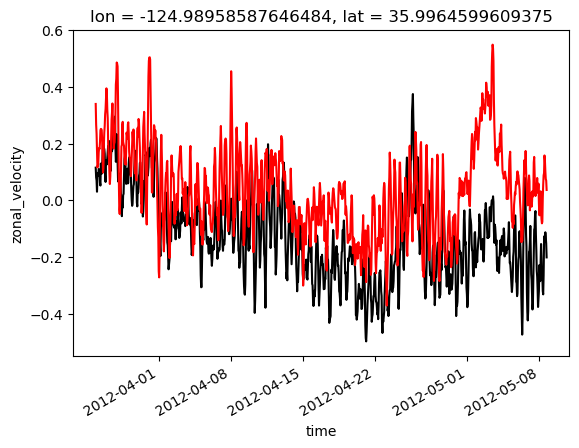

In [114]:
#plt.plot(_df.lon,_df.lat)

__ds.zonal_velocity.plot(c='k')
_df.zonal_velocity.plot(c='r')

In [21]:
tracks = ut.load_swot_tracks()

In [11]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
